In [ ]:
import nbpresent
nbpresent.__version__

In [1]:
%matplotlib inline

from ipywidgets import FloatProgress
from IPython.display import display
from ipywidgets import *

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
import pandas as pd
from sklearn.metrics import r2_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix


### Utilities

In [3]:
# Regression plot showing predicted gF scores vs original gF scores
def regression_plot(x,y,n,title):

    # fit a curve to the data using a least squares 1st order polynomial fit
    z = np.polyfit(x,y,1)

    p = np.poly1d(z)
    fit = p(x)

    # get the coordinates for the fit curve
    c_x = [np.min(x),np.max(x)]
    c_y = p(c_x)

    # predict y values of origional data using the fit
    p_y = z[0] * x + z[1]

    # calculate the y-error (residuals)
    y_err = y - p_y

    # create series of new test x-values to predict for
    p_x = np.arange(np.min(x),np.max(x)+1,1)

    # now calculate confidence intervals for new test x-series
    mean_x = np.mean(x)         # mean of x
    DF = n - z.size                            # degrees of freedom
    t = stats.t.ppf(0.95,DF)           # used for CI and PI bands
    s_err = np.sum(np.power(y_err,2))   # sum of the squares of the residuals

    #confs = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((p_x-mean_x),2)/((np.sum(np.power(x,2)))-n*(np.power(mean_x,2))))))
    confs = t * np.sqrt((s_err/(n-2)) * (1.0/n + (np.power((p_x-mean_x),2)/(np.sum(np.power(x - mean_x,2))))))
    # now predict y based on test x-values
    p_y = z[0]*p_x+z[1]

    # get lower and upper confidence limits based on predicted y and confidence intervals
    lower = p_y - abs(confs)
    upper = p_y + abs(confs)

    # set-up the plot
    #plt.axes().set_aspect('equal')
    plt.xlabel('Original score')
    plt.ylabel('Predicted score')
    plt.title(title)

    # plot sample data
    plt.plot(x,y,'bo')

    # plot line of best fit
    plt.plot(c_x,c_y,'r-',label='Regression line')

    # plot confidence limits
    plt.plot(p_x,lower,'b--',label='Lower confidence limit (95%)')
    plt.plot(p_x,upper,'b--',label='Upper confidence limit (95%)')

    # set coordinate limits
    plt.xlim(4,25)
    plt.ylim(5,25)

    # configure legend
    plt.legend(loc=0)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=10)

    # add text
    rho,p = stats.pearsonr(np.ravel(y),x)
    s = 'r={:0.2f}\np={:1.4f}'.format(rho,p)
    plt.text(20, 7, s, fontsize=12)

    
    
def mean_absolute_percentage_error(y_true, y_pred,perc=False):
    if perc:
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 
    else:
        return np.mean(np.abs((y_true - y_pred) / y_true))
    
def absolute_percentage_error(y_true, y_pred,perc=False):
    if perc:
        return np.abs((y_true - y_pred) / y_true) * 100 
    else:
        return np.abs((y_true - y_pred) / y_true)
    
def percentage_error(y_true, y_pred,perc=False):
    if perc:
        return (y_true - y_pred) / y_true * 100 
    else:
        return (y_true - y_pred) / y_true    
    
    
def plot_hist(data,n_bins,title,xlabel):
    plt.hist(data, bins=n_bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")

def plot_scatter(x,y,xlabel,ylabel):
    plt.plot(x,y,'bo')
    plt.axhline(y=0, ls='dashed')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
def plot_bar_h(df,title,rotation):
    # Setting the positions and width for the bars
    pos = list(range(len(df['pearson r'])))
    width = 0.2

    # Plotting the bars
    fig, ax = plt.subplots(figsize=(20,5))

    # Create a bar with pre_score data,
    # in position pos,
    plt.bar(pos,
            #using df['pre_score'] data,
            df['pearson r'],
            # of width
            width,
            # with alpha 0.5
            alpha=0.5,
            # with color
            color='#EE3224',
            # with label the first value in first_name
            label=df['model'].iloc[0])

    # Create a bar with mid_score data,
    # in position pos + some width buffer,
    plt.bar([p + width for p in pos],
            #using df['mid_score'] data,
            df['r squared'],
            # of width
            width,
            # with alpha 0.5
            alpha=0.5,
            # with color
            color='#F78F1E',
            # with label the second value in first_name
            label=df['model'].iloc[1])

    # Create a bar with post_score data,
    # in position pos + some width buffer,
    plt.bar([p + width*2 for p in pos],
            #using df['post_score'] data,
            df['mape'],
            # of width
            width,
            # with alpha 0.5
            alpha=0.5,
            # with color
            color='#FFC222',
            # with label the third value in first_name
            label=df['model'].iloc[2])

    # Set the y axis label
    ax.set_ylabel('Score')

    # Set the chart's title
    ax.set_title(title)

    # Set the position of the x ticks
    ax.set_xticks([p + 1.5 * width for p in pos])

    # Set the labels for the x ticks
    ax.set_xticklabels(df['model'],rotation=rotation)

    # Setting the x-axis and y-axis limits
    plt.xlim(min(pos)-width, max(pos)+width*4)
    plt.ylim([-0.1, max(df['pearson r'] + df['r squared'] + df['mape'])] )

    # Adding the legend and showing the plot
    plt.legend(['Pearson r', 'r squared', 'MAPE'], loc='upper left')
    plt.grid()
    plt.show()
    
def plot_bar_v(df,title):
    # Setting the positions and width for the bars
    pos = list(range(len(df['pearson r'])))
    width = 0.2

    # Plotting the bars
    fig, ax = plt.subplots(figsize=(5,20))

    # Create a bar with pre_score data,
    # in position pos,
    plt.barh(pos,
            #using df['pre_score'] data,
            df['pearson r'],
            # of width
            width,
            # with alpha 0.5
            alpha=0.5,
            # with color
            color='#EE3224',
            # with label the first value in first_name
            label=df['model'][0])

    # Create a bar with mid_score data,
    # in position pos + some width buffer,
    plt.barh([p + width for p in pos],
            #using df['mid_score'] data,
            df['r squared'],
            # of width
            width,
            # with alpha 0.5
            alpha=0.5,
            # with color
            color='#F78F1E',
            # with label the second value in first_name
            label=df['model'][1])

    # Create a bar with post_score data,
    # in position pos + some width buffer,
    plt.barh([p + width*2 for p in pos],
            #using df['post_score'] data,
            df['mape'],
            # of width
            width,
            # with alpha 0.5
            alpha=0.5,
            # with color
            color='#FFC222',
            # with label the third value in first_name
            label=df['model'][2])

    # Set the y axis label
    #ax.set_ylabel('Model Score')

    # Set the chart's title
    ax.set_title(title)

    # Set the position of the x ticks
    ax.set_yticks([p + 1.5 * width for p in pos])

    # Set the labels for the x ticks
    ax.set_yticklabels(df['model'])

    # Setting the x-axis and y-axis limits
    plt.ylim(min(pos)-width, max(pos)+width*4)
    plt.xlim([-0.1, max(df['pearson r'] + df['r squared'] + df['mape'])] )

    # Adding the legend and showing the plot
    plt.legend(['Pearson r', 'r squared', 'MAPE'], loc='upper right')
    plt.grid()
    
    
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tick_params(
    axis='both',    
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off',
    labelleft='off') # labels along the bottom edge are off    


### Import data

In [2]:
# finn's data set 
data = sio.loadmat('rfMRI_REST1_HCP_Q2')
gF = np.ravel(data['PMAT24_A_CR'])
n_subj = len(gF)
print('No. of subjects:',n_subj)

No. of subjects: 115


In [94]:
# extended data set
data = sio.loadmat('rfMRI_REST1_HCP_Q2')
gF = np.ravel(data['PMAT24_A_CR'])
data2 = sio.loadmat('rfMRI_REST1_HCP_S500.mat')
gF2 = np.ravel(data2['PMAT24_A_CR'])
gF = np.concatenate((gF,gF2))
n_subj = len(gF)
print('No. of subjects:',n_subj)

No. of subjects: 435


In [84]:
# Rest1 (improved preprocessing)
data = sio.loadmat('improved_preproc/rfMRI_REST1_HCP_Q2.mat')
gF = np.ravel(data['PMAT24_A_CR'])
n_subj = len(gF)

In [89]:
# Rest2 (improved preprocessing)
data = sio.loadmat('improved_preproc/rfMRI_REST2_HCP_Q2.mat')
gF = np.ravel(data['PMAT24_A_CR'])
n_subj = len(gF)

### gF score distribution 
The gF score is used to divide subjects in 2 or 3 classes.

[  5.   14.5]


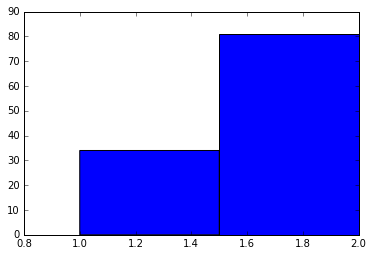

In [5]:
n_bins = 2

hist, bin_limits = np.histogram(gF, n_bins)
bins = np.digitize(gF, bin_limits[:-1])
plt.hist(bins,n_bins)
print(bin_limits[:-1])


[  5.          11.33333333  17.66666667]


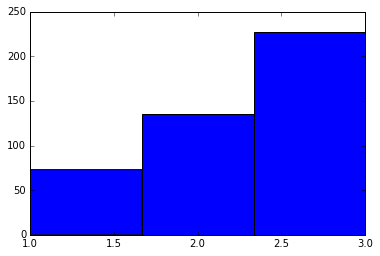

In [97]:
n_bins = 3

hist, bin_limits = np.histogram(gF, n_bins)
bins = np.digitize(gF, bin_limits[:-1])
plt.hist(bins,n_bins)
print(bin_limits[:-1])

## Classification task

Models that put all test data in the biggest class:
- PCA + Random Forest on Finn's data (2 classes) and Rest1 (2 and 3 classes) and extended data (2 and 3 classes) 
- Random Forest on Rest1 (2 and 3 classes)
- SVM + RFE on Finn's data (2 classes)


### Finn's data

#### PCA + SVM

[[11 23]
 [13 68]]
Accuracy: 0.686956521739
             precision    recall  f1-score   support

          1       0.46      0.32      0.38        34
          2       0.75      0.84      0.79        81

avg / total       0.66      0.69      0.67       115



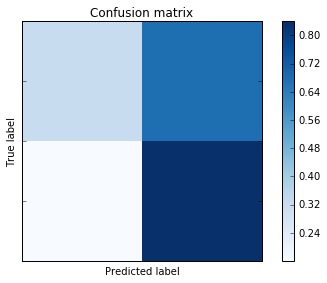

In [22]:
y_true = bins
y_pred = [ 1,  2,  1,  2,  2,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
   1,  2,  1,  1,  2,  2,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,
   1,  2,  1,  2,  1,  2,  1,  2,  1,  2,  2,  2,  2,  1,  2,  1,  2,  2,
   2,  2,  1,  2,  2,  2,  2,  2,  1,  2,  1,  1,  2,  2,  2,  2,  2,  2,
   2,  1,  2,  2,  2,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,  1,  2,  2,
   2,  2,  2,  2,  2,  2,  2]

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[ 2  7 12]
 [ 6  9 18]
 [ 8 10 43]]
Accuracy: 0.469565217391
             precision    recall  f1-score   support

          1       0.12      0.10      0.11        21
          2       0.35      0.27      0.31        33
          3       0.59      0.70      0.64        61

avg / total       0.43      0.47      0.45       115



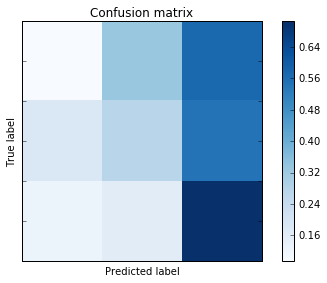

In [74]:
y_true = bins
y_pred = [ 2,  3,  2,  3,  1,  3,  3,  3,  1,  3,  3,  3,  3,  3,  3,  3,  3,  3,
   3,  3,  3,  3,  3,  3,  3,  1,  3,  3,  2,  3,  3,  3,  2,  3,  2,  3,
   3,  1,  1,  3,  2,  3,  2,  1,  3,  3,  2,  3,  3,  3,  3,  2,  3,  2,
   3,  3,  1,  3,  3,  1,  2,  2,  2,  3,  2,  2,  2,  1,  3,  1,  3,  1,
   3,  3,  1,  3,  3,  1,  3,  3,  3,  3,  2,  2,  2,  3,  3,  3,  3,  3,
   3,  1,  3,  2,  3,  3,  3,  3,  1,  2,  1,  3,  2,  3,  3,  2,  3,  3,
   2,  3,  2,  3,  2,  3,  3,]

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

#### SVM + RFE

[[ 0  2 19]
 [ 1  4 28]
 [ 2  7 52]]
Accuracy: 0.486956521739
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        21
          2       0.31      0.12      0.17        33
          3       0.53      0.85      0.65        61

avg / total       0.37      0.49      0.39       115



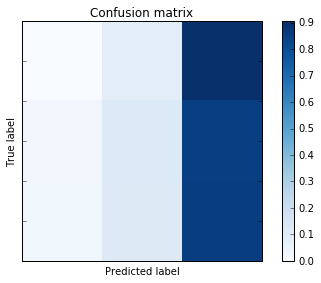

In [73]:
y_true = bins
y_pred = [ 3,  3,  3,  3,  1,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
   3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
   3,  3,  3,  3,  2,  3,  2,  3,  3,  3,  2,  3,  3,  3,  3,  3,  3,  3,
   3,  3,  3,  3,  3,  3,  2,  3,  2,  3,  3,  3,  2,  1,  3,  2,  3,  3,
   3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  2,  3,  2,  3,  3,  3,  3,  3,
   3,  3,  3,  2,  3,  3,  3,  3,  3,  3,  1,  3,  2,  3,  3,  3,  3,  3,
   2,  3,  3,  3,  2,  3,  3,]

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

#### Random Forest

[[ 8 26]
 [ 4 77]]
Accuracy: 0.739130434783
             precision    recall  f1-score   support

          1       0.67      0.24      0.35        34
          2       0.75      0.95      0.84        81

avg / total       0.72      0.74      0.69       115



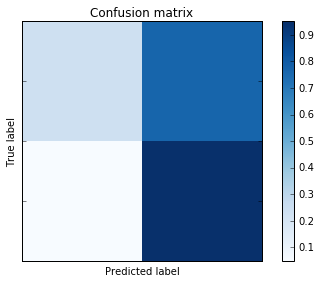

In [23]:
y_true = bins
y_pred = [ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,
   2,  1,  2,  2,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  1,  2,  2,  1,  2,  2,  2,  2,  1,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  2,  2,  2,  2,  2,  2,
   2,  1,  2,  2,  2,  2,  2,  2,  1,  2,  1,  2,  2,  2,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  2,  2]

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[ 3  4 14]
 [ 3  3 27]
 [ 2  4 55]]
Accuracy: 0.530434782609
             precision    recall  f1-score   support

          1       0.38      0.14      0.21        21
          2       0.27      0.09      0.14        33
          3       0.57      0.90      0.70        61

avg / total       0.45      0.53      0.45       115



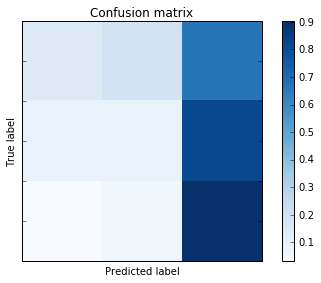

In [31]:
y_true = bins
y_pred = [ 3,  3,  3,  3,  3,  3,  3,  3,  1,  3,  1,  3,  3,  1,  3,  3,  3,  3,
3,  2,  2,  3,  3,  2,  3,  1,  3,  2,  3,  3,  3,  3,  2,  3,  3,  3,
3,  1,  3,  3,  3,  3,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
3,  3,  3,  3,  3,  1,  3,  3,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,
3,  3,  3,  3,  3,  3,  3,  3,  2,  2,  3,  2,  3,  3,  3,  3,  3,  3,
3,  3,  3,  3,  3,  3,  3,  3,  1,  3,  1,  3,  3,  3,  3,  3,  3,  3,
3,  3,  3,  3,  3,  3,  3]

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

#### PCA + Random Forest

[[ 3  4 14]
 [ 3  3 27]
 [ 2  4 55]]
Accuracy: 0.530434782609
             precision    recall  f1-score   support

          1       0.38      0.14      0.21        21
          2       0.27      0.09      0.14        33
          3       0.57      0.90      0.70        61

avg / total       0.45      0.53      0.45       115



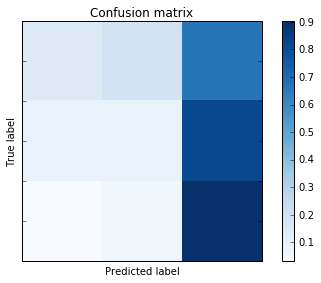

In [55]:
y_true = bins
y_pred = [ 3,  3,  3,  3,  3,  3,  3,  3,  1,  3,  1,  3,  3,  1,  3,  3,  3,  3,
   3,  2,  2,  3,  3,  2,  3,  1,  3,  2,  3,  3,  3,  3,  2,  3,  3,  3,
   3,  1,  3,  3,  3,  3,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
   3,  3,  3,  3,  3,  1,  3,  3,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,
   3,  3,  3,  3,  3,  3,  3,  3,  2,  2,  3,  2,  3,  3,  3,  3,  3,  3,
   3,  3,  3,  3,  3,  3,  3,  3,  1,  3,  1,  3,  3,  3,  3,  3,  3,  3,
   3,  3,  3,  3,  3,  3,  3,]

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

#### PCA + kNN

[[10 24]
 [15 66]]
Accuracy: 0.660869565217
             precision    recall  f1-score   support

          1       0.40      0.29      0.34        34
          2       0.73      0.81      0.77        81

avg / total       0.63      0.66      0.64       115



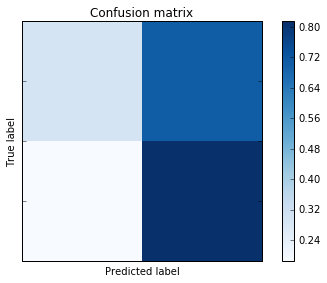

In [25]:
y_true = bins
y_pred = [ 2,  2,  1,  2,  2,  2,  2,  2,  1,  1,  1,  2,  2,  2,  2,  1,  2,  1,
   2,  2,  2,  2,  2,  2,  1,  1,  2,  2,  2,  2,  2,  1,  2,  2,  2,  1,
   2,  2,  2,  2,  2,  1,  2,  1,  1,  2,  2,  1,  2,  2,  2,  2,  2,  2,
   2,  2,  2,  1,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  2,  2,
   2,  2,  1,  2,  1,  2,  1,  2,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,
   2,  1,  1,  2,  2,  2,  2,  1,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  2,  2]

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[ 8  7  6]
 [ 4 10 19]
 [18  6 37]]
Accuracy: 0.478260869565
             precision    recall  f1-score   support

          1       0.27      0.38      0.31        21
          2       0.43      0.30      0.36        33
          3       0.60      0.61      0.60        61

avg / total       0.49      0.48      0.48       115



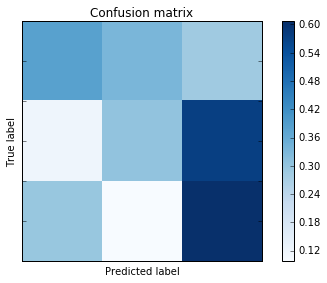

In [32]:
y_true = bins
y_pred = [ 2,  2,  1,  3,  1,  3,  3,  3,  2,  1,  1,  3,  3,  3,  3,  1,  3,  1,
   3,  2,  3,  3,  3,  3,  1,  2,  3,  3,  1,  3,  3,  1,  1,  3,  3,  2,
   3,  2,  3,  3,  1,  1,  2,  2,  2,  1,  1,  1,  3,  3,  2,  2,  3,  1,
   3,  3,  3,  1,  3,  1,  2,  2,  2,  3,  1,  2,  2,  3,  3,  2,  3,  2,
   3,  3,  1,  1,  1,  3,  1,  3,  3,  1,  3,  1,  1,  3,  2,  3,  3,  3,
   3,  2,  1,  3,  3,  3,  3,  1,  2,  1,  2,  3,  3,  3,  3,  1,  3,  3,
   3,  3,  3,  3,  3,  3,  3]

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

#### kNN

[[ 8 26]
 [11 70]]
Accuracy: 0.678260869565
             precision    recall  f1-score   support

          1       0.42      0.24      0.30        34
          2       0.73      0.86      0.79        81

avg / total       0.64      0.68      0.65       115



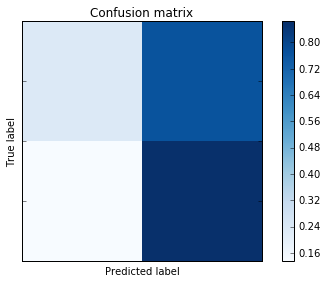

In [36]:
y_true = bins
y_pred = [ 2,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  2,  1,
   2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  2,  2,  2,  1,
   2,  2,  1,  2,  2,  1,  2,  1,  1,  2,  2,  1,  2,  2,  1,  2,  2,  2,
   2,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  2,  2,
   2,  2,  1,  2,  2,  2,  2,  1,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,
   2,  1,  1,  2,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  2,  2,]

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[ 8  7  6]
 [ 2 13 18]
 [16 14 31]]
Accuracy: 0.452173913043
             precision    recall  f1-score   support

          1       0.31      0.38      0.34        21
          2       0.38      0.39      0.39        33
          3       0.56      0.51      0.53        61

avg / total       0.46      0.45      0.46       115



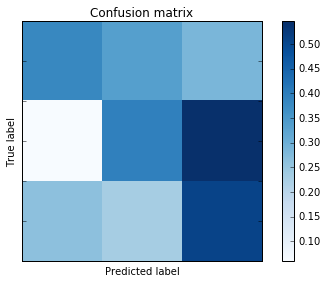

In [33]:
y_true = bins
y_pred = [ 3,  2,  1,  3,  1,  3,  3,  3,  2,  1,  1,  3,  1,  1,  3,  1,  3,  1,
   3,  2,  3,  3,  3,  3,  3,  2,  3,  3,  2,  2,  3,  1,  2,  3,  2,  2,
   3,  2,  1,  3,  1,  1,  2,  2,  2,  1,  1,  1,  2,  3,  1,  2,  2,  1,
   3,  3,  3,  1,  3,  2,  2,  3,  2,  2,  3,  2,  2,  2,  3,  1,  2,  2,
   3,  3,  1,  3,  2,  3,  1,  1,  3,  1,  3,  1,  1,  3,  2,  3,  3,  3,
   3,  2,  1,  3,  3,  3,  2,  2,  3,  2,  2,  3,  3,  3,  3,  2,  3,  3,
   3,  3,  3,  2,  3,  3,  3,]

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

### Rest1 (improved preprocessing)

#### PCA + SVM

[[ 2 32]
 [ 6 77]]
Accuracy: 0.675213675214
             precision    recall  f1-score   support

          1       0.25      0.06      0.10        34
          2       0.71      0.93      0.80        83

avg / total       0.57      0.68      0.60       117



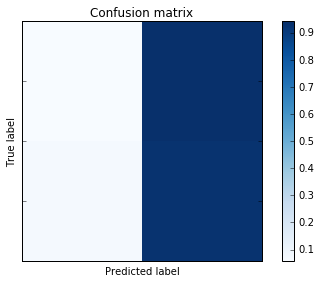

In [87]:
y_true = bins
y_pred = [ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  2,  1,  1,  2,  2,  2,  2,  2,  1,  2,  2,  2,  2,
   2,  1,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  2,
   2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  2,  2,  2,
   2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  2,  2,  2,  1,]

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[ 0  7 14]
 [ 1  9 24]
 [ 2  5 55]]
Accuracy: 0.547008547009
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        21
          2       0.43      0.26      0.33        34
          3       0.59      0.89      0.71        62

avg / total       0.44      0.55      0.47       117



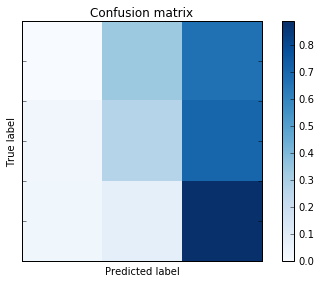

In [80]:
y_true = bins
y_pred = [ 2,  3,  2,  3,  1,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  2,  3,  3,
   3,  3,  3,  3,  3,  3,  2,  3,  3,  3,  3,  3,  3,  3,  2,  3,  3,  3,
   3,  2,  3,  3,  3,  3,  2,  1,  3,  3,  3,  3,  3,  2,  3,  2,  3,  3,
   3,  1,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  2,  2,  3,  2,  3,  2,
   3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  2,  3,  3,  2,  3,  3,  3,
   3,  3,  3,  2,  3,  3,  3,  3,  3,  3,  3,  2,  3,  2,  3,  3,  3,  2,
   3,  3,  3,  3,  3,  3,  2,  3,  3,]

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

#### PCA + kNN

[[20 14]
 [40 43]]
Accuracy: 0.538461538462
             precision    recall  f1-score   support

          1       0.33      0.59      0.43        34
          2       0.75      0.52      0.61        83

avg / total       0.63      0.54      0.56       117



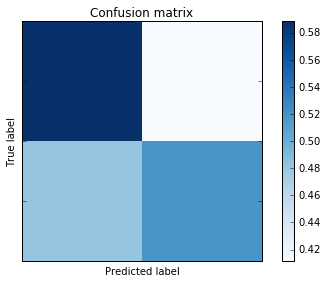

In [41]:
y_true = bins
y_pred = [ 1,  1,  1,  1,  1,  1,  2,  2,  1,  2,  2,  2,  1,  2,  2,  2,  1,  1,
   1,  2,  2,  2,  2,  2,  1,  2,  2,  2,  1,  2,  2,  2,  2,  2,  1,  2,
   2,  2,  2,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  1,  1,  1,
   1,  1,  1,  2,  1,  1,  1,  1,  2,  2,  1,  2,  2,  1,  2,  1,  1,  1,
   1,  1,  2,  2,  1,  2,  2,  2,  1,  1,  2,  1,  1,  1,  1,  2,  1,  2,
   2,  2,  2,  1,  1,  1,  1,  1,  1,  2,  2,  1,  1,  2,  2,  2,  2,  2,
   1,  2,  2,  2,  2,  2,  1,  1,  1,]

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[14  4  3]
 [15 11  8]
 [23 13 26]]
Accuracy: 0.435897435897
             precision    recall  f1-score   support

          1       0.27      0.67      0.38        21
          2       0.39      0.32      0.35        34
          3       0.70      0.42      0.53        62

avg / total       0.53      0.44      0.45       117



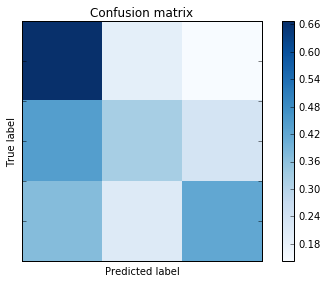

In [44]:
y_true = bins
y_pred = [ 2,  2,  1,  1,  1,  2,  3,  3,  1,  2,  1,  3,  1,  3,  3,  2,  2,  1,
   1,  3,  3,  3,  3,  3,  1,  2,  3,  3,  2,  1,  2,  3,  1,  3,  1,  3,
   3,  2,  2,  3,  1,  1,  1,  2,  1,  2,  1,  1,  1,  2,  2,  1,  1,  2,
   1,  2,  1,  1,  1,  1,  1,  1,  3,  3,  2,  3,  1,  2,  1,  2,  1,  2,
   2,  1,  3,  3,  2,  3,  1,  3,  1,  1,  3,  1,  1,  1,  1,  3,  1,  3,
   3,  1,  3,  2,  1,  1,  1,  2,  2,  3,  1,  1,  2,  3,  3,  1,  3,  1,
   2,  3,  1,  3,  3,  3,  1,  1,  1,]

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

#### kNN

[[16 18]
 [23 60]]
Accuracy: 0.649572649573
             precision    recall  f1-score   support

          1       0.41      0.47      0.44        34
          2       0.77      0.72      0.75        83

avg / total       0.66      0.65      0.66       117



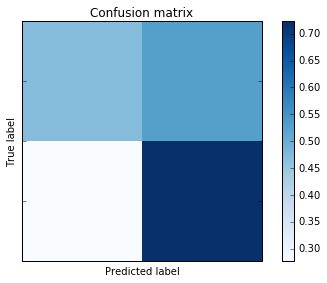

In [42]:
y_true = bins
y_pred = [ 1,  1,  2,  2,  1,  1,  2,  2,  1,  2,  1,  2,  1,  2,  2,  2,  2,  1,
   2,  2,  2,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
   2,  2,  1,  2,  2,  1,  1,  2,  2,  1,  2,  2,  2,  1,  2,  1,  1,  2,
   1,  1,  1,  1,  2,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  1,
   2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  2,  1,  2,  1,  1,  2,  2,  2,
   2,  2,  2,  1,  1,  1,  2,  2,  2,  2,  1,  2,  2,  2,  1,  2,  2,  1,
   1,  2,  1,  2,  2,  2,  1,  2,  1,]

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[ 9  9  3]
 [12 13  9]
 [ 8 30 24]]
Accuracy: 0.393162393162
             precision    recall  f1-score   support

          1       0.31      0.43      0.36        21
          2       0.25      0.38      0.30        34
          3       0.67      0.39      0.49        62

avg / total       0.48      0.39      0.41       117



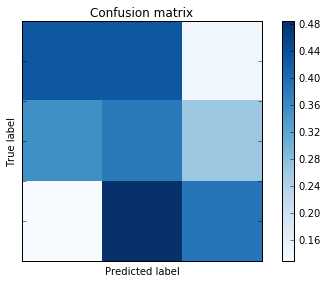

In [45]:
y_true = bins
y_pred = [ 1,  1,  2,  3,  1,  2,  3,  2,  1,  2,  1,  3,  1,  2,  3,  2,  2,  1,
   2,  3,  3,  3,  3,  3,  1,  1,  3,  3,  2,  1,  2,  3,  2,  2,  2,  3,
   3,  1,  2,  3,  2,  2,  1,  2,  2,  2,  2,  1,  1,  2,  2,  2,  1,  2,
   2,  2,  2,  1,  2,  1,  1,  1,  2,  3,  2,  3,  1,  2,  2,  2,  2,  2,
   2,  2,  3,  3,  2,  3,  2,  3,  3,  2,  3,  1,  3,  1,  1,  3,  2,  3,
   3,  2,  2,  2,  2,  2,  2,  2,  2,  3,  1,  3,  2,  3,  2,  3,  3,  1,
   1,  3,  1,  1,  3,  3,  2,  3,  1,]

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

### Rest 2 (improved preprocessing)

#### PCA + SVM

[[ 1 31]
 [ 4 78]]
Accuracy: 0.69298245614
             precision    recall  f1-score   support

          1       0.20      0.03      0.05        32
          2       0.72      0.95      0.82        82

avg / total       0.57      0.69      0.60       114



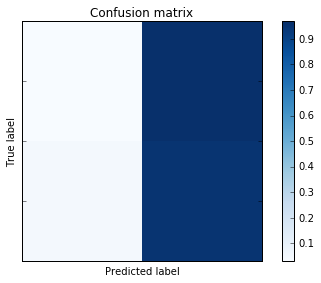

In [91]:
y_true = bins
y_pred = [ 1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  2,  2,  2,  1,  2,  2,  2,  2,  1,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
   2,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  2,]

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[ 0  5 15]
 [ 0  6 26]
 [ 1  6 55]]
Accuracy: 0.535087719298
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        20
          2       0.35      0.19      0.24        32
          3       0.57      0.89      0.70        62

avg / total       0.41      0.54      0.45       114



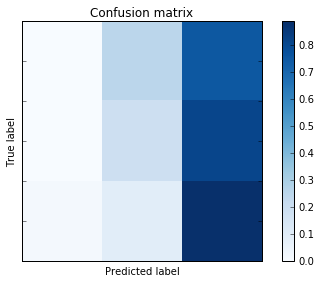

In [93]:
y_true = bins
y_pred = [ 2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  2,  3,  3,  3,  3,
   3,  3,  3,  3,  3,  3,  2,  3,  3,  3,  2,  3,  3,  3,  3,  2,  3,  3,
   3,  3,  3,  2,  3,  3,  3,  2,  1,  3,  2,  3,  3,  2,  3,  3,  3,  3,
   3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  2,  2,  3,  3,  3,  3,
   3,  3,  3,  3,  3,  3,  3,  3,  2,  2,  3,  2,  3,  3,  3,  3,  3,  3,
   3,  3,  3,  3,  3,  2,  3,  3,  3,  3,  2,  3,  3,  3,  3,  3,  3,  3,
   3,  3,  3,  2,  3,  3,]

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

#### PCA + kNN

[[10 22]
 [27 55]]
Accuracy: 0.570175438596
             precision    recall  f1-score   support

          1       0.27      0.31      0.29        32
          2       0.71      0.67      0.69        82

avg / total       0.59      0.57      0.58       114



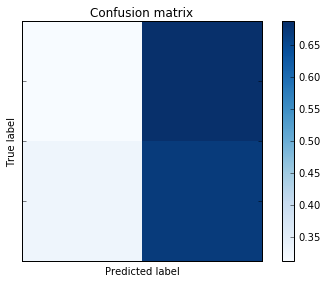

In [59]:
y_true = bins
y_pred = [ 1,  1,  2,  2,  2,  1,  2,  1,  2,  1,  2,  2,  1,  1,  2,  2,  2,  2,
   1,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  2,  1,  1,
   2,  2,  2,  1,  2,  2,  1,  1,  2,  2,  1,  2,  2,  2,  2,  1,  2,  1,
   1,  2,  2,  1,  1,  1,  2,  2,  2,  1,  2,  2,  2,  1,  2,  2,  2,  1,
   2,  2,  1,  2,  2,  2,  2,  2,  1,  2,  1,  2,  1,  1,  2,  1,  2,  2,
   2,  1,  1,  2,  1,  1,  2,  2,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  2,]

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[ 0 17  3]
 [ 4 17 11]
 [ 5 32 25]]
Accuracy: 0.368421052632
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        20
          2       0.26      0.53      0.35        32
          3       0.64      0.40      0.50        62

avg / total       0.42      0.37      0.37       114



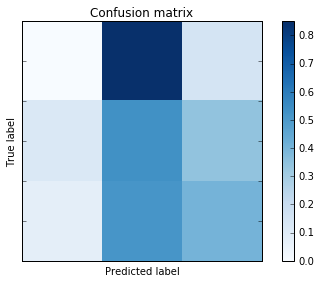

In [49]:
y_true = bins
y_pred = [ 2,  2,  3,  2,  3,  2,  2,  1,  3,  2,  2,  3,  2,  2,  3,  2,  2,  3,
   2,  3,  2,  2,  3,  3,  3,  2,  3,  2,  2,  2,  1,  3,  2,  2,  2,  2,
   3,  3,  2,  2,  3,  2,  2,  2,  2,  2,  2,  3,  3,  2,  2,  2,  2,  2,
   1,  3,  1,  2,  2,  1,  2,  2,  3,  2,  2,  1,  2,  2,  3,  3,  2,  2,
   3,  3,  2,  3,  1,  3,  3,  3,  2,  3,  2,  3,  2,  2,  3,  2,  3,  1,
   3,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  1,  3,  3,  2,  2,  2,
   2,  3,  2,  3,  3,  3,]

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

#### kNN

[[ 4 28]
 [12 70]]
Accuracy: 0.649122807018
             precision    recall  f1-score   support

          1       0.25      0.12      0.17        32
          2       0.71      0.85      0.78        82

avg / total       0.58      0.65      0.61       114



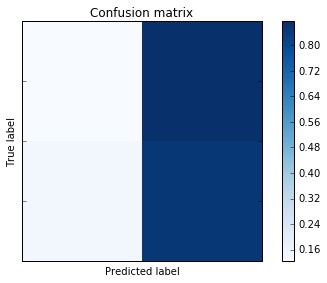

In [60]:
y_true = bins
y_pred = [ 1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  2,  2,  2,  2,  2,
   1,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
   2,  2,  2,  1,  2,  2,  1,  1,  1,  2,  2,  2,  2,  2,  2,  1,  2,  2,
   2,  2,  2,  2,  2,  2,  2,  1,  2,  1,  2,  2,  2,  1,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
   2,  1,  2,  2,  2,  2,  2,  2,  2,  1,  2,  2,  2,  2,  1,  2,  2,  2,
   2,  2,  2,  2,  2,  2,]

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[ 0 14  6]
 [ 0 18 14]
 [ 0 36 26]]
Accuracy: 0.385964912281
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        20
          2       0.26      0.56      0.36        32
          3       0.57      0.42      0.48        62

avg / total       0.38      0.39      0.36       114



C:\Users\Paola\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


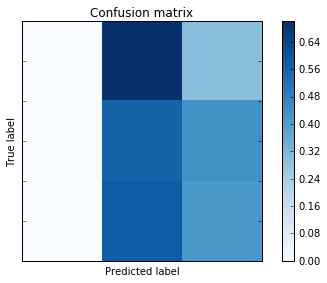

In [83]:
y_true = bins
y_pred = [ 2,  3,  3,  2,  3,  2,  2,  2,  3,  2,  2,  3,  2,  2,  2,  2,  3,  2,
   2,  3,  3,  2,  3,  3,  3,  2,  3,  2,  2,  2,  2,  3,  3,  2,  2,  3,
   2,  3,  2,  2,  3,  2,  2,  2,  2,  2,  2,  3,  3,  2,  2,  2,  2,  2,
   3,  2,  2,  2,  3,  3,  2,  2,  3,  2,  3,  2,  2,  2,  3,  3,  2,  2,
   3,  3,  2,  3,  2,  2,  3,  3,  2,  3,  2,  3,  3,  2,  3,  2,  3,  2,
   3,  2,  2,  2,  2,  2,  2,  3,  3,  2,  3,  2,  2,  3,  2,  2,  2,  2,
   3,  3,  2,  3,  3,  3,]

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

### Extended data set

#### PCA + SVM

[[ 43  94]
 [ 64 234]]
Accuracy: 0.636781609195
             precision    recall  f1-score   support

          1       0.40      0.31      0.35       137
          2       0.71      0.79      0.75       298

avg / total       0.62      0.64      0.62       435



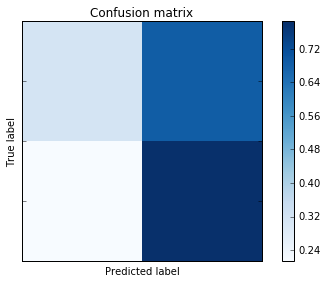

In [96]:
y_true = bins
y_pred = [ 2,  2,  2,  2,  2,  2,  1,  2,  1,  1,  2,  2,  1,  2,  1,  1,  2,  2,
   1,  1,  2,  2,  1,  2,  2,  1,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,
   2,  2,  1,  2,  2,  2,  2,  2,  1,  1,  2,  1,  2,  2,  2,  2,  2,  1,
   1,  2,  1,  2,  1,  2,  1,  2,  2,  2,  2,  1,  2,  1,  2,  1,  2,  2,
   2,  2,  1,  2,  2,  2,  2,  2,  1,  2,  2,  1,  2,  2,  1,  2,  2,  2,
   2,  2,  1,  2,  2,  2,  2,  2,  1,  2,  2,  2,  2,  2,  1,  2,  2,  2,
   2,  2,  1,  2,  2,  2,  2,  2,  1,  2,  1,  1,  2,  2,  1,  1,  2,  1,
   2,  2,  2,  1,  2,  2,  2,  2,  1,  2,  2,  2,  1,  2,  1,  2,  2,  2,
   2,  2,  2,  1,  1,  1,  2,  1,  2,  2,  1,  2,  2,  1,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  2,  1,  1,  2,  2,  2,  1,  2,  1,  2,  2,  2,  2,
   2,  1,  2,  1,  2,  2,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
   1,  2,  2,  2,  2,  2,  1,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,
   2,  1,  1,  1,  2,  2,  2,  1,  2,  2,  2,  2,  1,  1,  2,  1,  2,  2,
   2,  1,  1,  2,  2,  2,  2,  2,  1,  2,  1,  2,  1,  2,  2,  2,  2,  2,
   2,  2,  1,  2,  2,  1,  2,  2,  2,  2,  2,  2,  1,  2,  2,  2,  2,  2,
   2,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  2,  2,  2,  2,
   1,  1,  1,  2,  2,  2,  2,  1,  2,  1,  2,  2,  2,  1,  2,  2,  1,  2,
   1,  2,  2,  1,  1,  1,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  2,  1,  2,  2,  2,  2,  2,  1,  1,  2,  2,  2,  1,
   2,  1,  2,  2,  1,  2,  2,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,
   2,  2,  2,  2,  1,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  2,  1,  2,  2,
   1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  2,  2,  2,
   1,  1,  2,  2,  2,  2,  2,  1,  2,  2,  2,  1,  2,  2,  2,  1,  2,  2,
   1,  2,  2,]

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[ 14  21  38]
 [ 19  50  66]
 [ 21  64 142]]
Accuracy: 0.473563218391
             precision    recall  f1-score   support

          1       0.26      0.19      0.22        73
          2       0.37      0.37      0.37       135
          3       0.58      0.63      0.60       227

avg / total       0.46      0.47      0.47       435



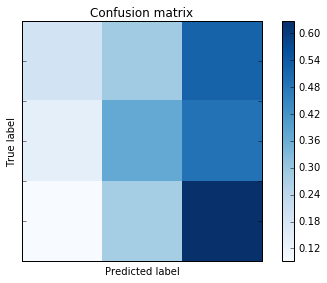

In [98]:
y_true = bins
y_pred = [ 2,  2,  3,  3,  3,  3,  2,  3,  1,  2,  3,  3,  2,  2,  1,  2,  2,  3,
   1,  3,  3,  2,  1,  3,  3,  1,  3,  3,  1,  3,  3,  2,  2,  3,  3,  3,
   3,  2,  2,  3,  2,  3,  3,  1,  2,  2,  3,  2,  3,  3,  3,  2,  2,  2,
   2,  1,  2,  2,  1,  1,  2,  2,  3,  3,  2,  2,  2,  1,  3,  1,  3,  1,
   2,  3,  2,  3,  3,  3,  3,  3,  2,  3,  3,  2,  3,  3,  3,  3,  3,  2,
   3,  3,  3,  2,  3,  3,  2,  2,  1,  3,  3,  3,  2,  2,  2,  3,  3,  3,
   2,  3,  2,  3,  2,  3,  2,  3,  2,  2,  2,  1,  3,  2,  2,  1,  2,  2,
   2,  3,  3,  3,  3,  2,  3,  1,  3,  2,  2,  3,  2,  3,  2,  3,  3,  3,
   3,  1,  3,  3,  1,  1,  3,  3,  3,  2,  3,  2,  2,  2,  3,  3,  3,  2,
   3,  2,  3,  3,  2,  3,  2,  1,  3,  2,  3,  2,  3,  1,  3,  2,  3,  3,
   3,  1,  3,  1,  3,  3,  2,  2,  2,  3,  3,  3,  3,  2,  2,  2,  3,  2,
   2,  3,  3,  2,  3,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  2,  3,  3,
   3,  1,  1,  3,  3,  3,  2,  1,  3,  3,  2,  2,  1,  1,  2,  2,  3,  3,
   3,  3,  2,  3,  3,  3,  3,  3,  1,  3,  3,  3,  1,  3,  3,  3,  3,  3,
   3,  2,  1,  3,  3,  1,  2,  3,  3,  2,  3,  3,  3,  2,  2,  3,  2,  3,
   3,  3,  3,  1,  1,  3,  2,  3,  3,  3,  3,  3,  2,  3,  3,  3,  3,  3,
   2,  1,  2,  3,  3,  3,  2,  2,  3,  1,  3,  1,  3,  2,  3,  2,  2,  2,
   1,  2,  3,  1,  3,  1,  2,  1,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
   1,  2,  3,  3,  3,  2,  1,  2,  2,  3,  3,  3,  2,  1,  3,  3,  3,  2,
   3,  2,  3,  3,  2,  3,  3,  3,  3,  3,  1,  3,  3,  3,  1,  2,  3,  3,
   3,  3,  3,  3,  3,  1,  3,  3,  2,  3,  3,  3,  3,  1,  2,  3,  3,  3,
   3,  3,  3,  3,  3,  3,  1,  3,  2,  3,  2,  3,  3,  2,  2,  2,  3,  3,
   2,  3,  3,  3,  3,  3,  3,  3,  3,  2,  3,  2,  1,  3,  3,  2,  3,  2,
   2,  3,  3,  2,  3,  3,  2,  1,  3,  3,  3,  2,  1,  2,  1,  2,  2,  3,
   2,  3,  3,]

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

#### PCA + kNN

[[ 39  98]
 [ 69 229]]
Accuracy: 0.616091954023
             precision    recall  f1-score   support

          1       0.36      0.28      0.32       137
          2       0.70      0.77      0.73       298

avg / total       0.59      0.62      0.60       435



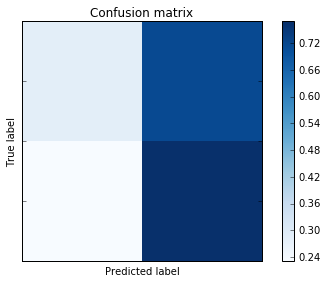

In [64]:
y_true = bins
y_pred = [ 2,  2,  2,  2,  2,  2,  1,  2,  1,  2,  2,  2,  2,  1,  2,  2,  2,  2,
   2,  2,  1,  1,  1,  2,  2,  1,  2,  1,  2,  2,  1,  1,  2,  1,  2,  1,
   2,  2,  2,  1,  2,  2,  2,  1,  1,  2,  1,  1,  2,  1,  2,  2,  2,  1,
   1,  1,  2,  1,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
   2,  1,  1,  2,  2,  2,  2,  2,  2,  1,  2,  1,  2,  1,  2,  2,  2,  2,
   2,  1,  1,  2,  2,  2,  2,  2,  2,  2,  1,  1,  2,  2,  2,  2,  2,  2,
   2,  1,  2,  2,  2,  2,  2,  1,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  2,  2,  1,  1,  2,  1,  2,  1,  2,  1,  2,  2,  2,
   2,  2,  2,  2,  2,  2,  1,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,  1,
   2,  2,  1,  2,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,  1,  2,  2,
   2,  2,  1,  2,  2,  2,  2,  2,  1,  2,  2,  2,  2,  1,  2,  2,  2,  2,
   1,  2,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
   2,  2,  2,  2,  1,  1,  2,  2,  2,  2,  2,  2,  1,  1,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,  1,  1,  2,  2,  2,
   1,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  2,
   1,  2,  2,  2,  2,  2,  1,  2,  1,  2,  2,  2,  2,  1,  1,  1,  2,  1,
   1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  2,  2,  1,  2,
   1,  2,  2,  1,  2,  2,  2,  1,  2,  2,  2,  1,  2,  1,  2,  1,  2,  2,
   2,  1,  2,  1,  2,  1,  2,  2,  2,  2,  2,  2,  2,  1,  2,  2,  2,  2,
   2,  2,  1,  2,  1,  1,  2,  1,  2,  2,  2,  2,  2,  1,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  1,  2,  2,
   2,  2,  1,  2,  2,  2,  2,  2,  1,  2,  1,  1,  2,  1,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  2,  2,
   2,  1,  2,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,  1,  2,  1,  1,
   2,  2,  1,]

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[ 23  20  30]
 [ 27  43  65]
 [ 51  62 114]]
Accuracy: 0.413793103448
             precision    recall  f1-score   support

          1       0.23      0.32      0.26        73
          2       0.34      0.32      0.33       135
          3       0.55      0.50      0.52       227

avg / total       0.43      0.41      0.42       435



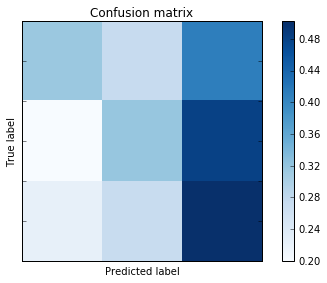

In [68]:
y_true = bins
y_pred =[ 3,  3,  3,  3,  2,  3,  1,  3,  2,  3,  1,  3,  3,  1,  2,  3,  3,  1,
   3,  3,  1,  1,  1,  3,  3,  1,  3,  2,  2,  3,  2,  1,  2,  1,  2,  2,
   3,  1,  3,  1,  3,  3,  2,  2,  2,  1,  2,  1,  3,  1,  3,  2,  2,  1,
   2,  1,  3,  2,  3,  1,  2,  3,  3,  2,  3,  2,  2,  2,  3,  3,  3,  1,
   3,  1,  2,  1,  3,  3,  3,  3,  3,  1,  2,  1,  1,  2,  3,  3,  3,  3,
   2,  2,  1,  1,  3,  3,  2,  3,  2,  2,  2,  2,  3,  3,  3,  2,  3,  3,
   3,  1,  3,  3,  3,  3,  1,  2,  1,  3,  3,  2,  3,  3,  2,  2,  3,  2,
   2,  3,  3,  3,  3,  2,  3,  1,  1,  3,  1,  2,  1,  2,  1,  3,  3,  3,
   1,  1,  3,  3,  3,  1,  2,  2,  3,  2,  3,  2,  3,  3,  2,  3,  1,  2,
   2,  3,  1,  3,  1,  3,  3,  2,  3,  3,  1,  2,  3,  3,  3,  2,  3,  2,
   2,  2,  2,  3,  2,  3,  1,  3,  2,  2,  3,  1,  3,  2,  3,  2,  3,  3,
   1,  2,  1,  2,  2,  1,  3,  1,  3,  3,  3,  3,  3,  3,  3,  2,  3,  3,
   3,  3,  3,  3,  2,  1,  3,  2,  3,  3,  1,  3,  1,  2,  2,  2,  2,  3,
   3,  3,  3,  2,  3,  1,  3,  3,  3,  3,  1,  2,  2,  1,  1,  3,  3,  3,
   2,  3,  3,  1,  3,  3,  2,  3,  1,  3,  2,  3,  2,  3,  2,  3,  2,  3,
   1,  3,  3,  1,  3,  3,  1,  3,  2,  3,  2,  3,  3,  1,  1,  2,  2,  1,
   1,  2,  1,  3,  1,  3,  3,  3,  2,  2,  3,  1,  1,  1,  3,  3,  1,  2,
   1,  2,  3,  2,  3,  3,  3,  1,  3,  3,  3,  1,  3,  2,  3,  1,  3,  3,
   3,  2,  3,  1,  2,  2,  1,  2,  3,  3,  3,  3,  2,  1,  3,  3,  3,  3,
   2,  2,  2,  2,  1,  1,  2,  1,  3,  2,  1,  1,  3,  1,  3,  2,  2,  3,
   3,  1,  2,  1,  3,  1,  1,  2,  3,  1,  2,  3,  2,  3,  3,  1,  2,  2,
   2,  3,  1,  3,  3,  2,  2,  3,  1,  3,  2,  1,  3,  1,  3,  3,  2,  3,
   1,  2,  2,  3,  3,  2,  3,  2,  3,  3,  3,  3,  3,  1,  1,  2,  3,  2,
   3,  1,  2,  3,  3,  3,  1,  3,  3,  2,  2,  3,  3,  3,  1,  3,  1,  2,
   1,  3,  1,]

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

#### kNN

[[ 30 107]
 [ 46 252]]
Accuracy: 0.648275862069
             precision    recall  f1-score   support

          1       0.39      0.22      0.28       137
          2       0.70      0.85      0.77       298

avg / total       0.61      0.65      0.61       435



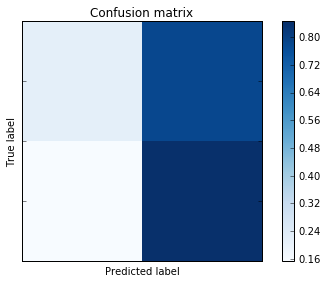

In [65]:
y_true = bins
y_pred =[ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  1,  2,  2,
   2,  2,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,
   1,  2,  2,  2,  2,  2,  2,  1,  1,  2,  2,  1,  2,  1,  2,  2,  2,  1,
   1,  1,  2,  1,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  2,  1,  2,  2,  2,  2,  2,  2,
   2,  1,  1,  1,  2,  2,  2,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,
   2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  2,  2,  1,  1,  2,  2,  2,  2,  2,  1,  2,  2,  2,
   2,  2,  2,  2,  2,  1,  1,  2,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
   2,  2,  1,  2,  2,  2,  2,  2,  1,  2,  2,  2,  2,  1,  2,  2,  2,  2,
   1,  2,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
   2,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  1,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
   1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  2,  2,  2,  1,  2,
   1,  1,  2,  1,  2,  2,  2,  2,  1,  2,  2,  2,  2,  2,  1,  1,  2,  2,
   1,  1,  2,  2,  1,  2,  2,  2,  2,  1,  1,  2,  1,  1,  2,  2,  2,  2,
   2,  2,  2,  1,  2,  2,  1,  2,  2,  2,  2,  1,  2,  1,  2,  1,  2,  2,
   2,  1,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
   2,  2,  2,  2,  1,  2,  2,  1,  2,  2,  2,  2,  2,  1,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  1,  2,  2,
   2,  2,  1,  2,  1,  2,  2,  2,  2,  2,  2,  1,  2,  1,  2,  2,  2,  2,
   2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  2,  2,
   2,  1,  2,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,
   2,  2,  1,]

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[ 15  25  33]
 [ 18  48  69]
 [ 29  76 122]]
Accuracy: 0.425287356322
             precision    recall  f1-score   support

          1       0.24      0.21      0.22        73
          2       0.32      0.36      0.34       135
          3       0.54      0.54      0.54       227

avg / total       0.42      0.43      0.42       435



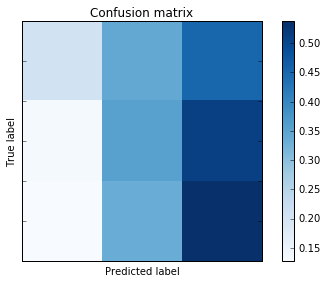

In [69]:
y_true = bins
y_pred =[ 3,  3,  3,  3,  3,  3,  2,  1,  2,  3,  1,  3,  2,  1,  2,  1,  3,  2,
   3,  3,  1,  1,  1,  3,  3,  1,  3,  3,  2,  3,  2,  3,  3,  1,  2,  2,
   2,  1,  3,  3,  2,  3,  2,  1,  2,  1,  2,  2,  3,  2,  2,  2,  2,  1,
   2,  1,  3,  2,  1,  3,  2,  3,  2,  3,  2,  2,  2,  3,  3,  3,  3,  3,
   3,  3,  2,  2,  2,  3,  3,  3,  3,  1,  3,  1,  2,  2,  2,  3,  3,  3,
   3,  2,  1,  2,  3,  3,  3,  2,  2,  2,  1,  3,  3,  3,  3,  3,  2,  3,
   3,  2,  3,  3,  3,  3,  3,  3,  1,  3,  3,  2,  3,  3,  2,  2,  3,  2,
   2,  3,  3,  3,  3,  2,  3,  1,  1,  3,  3,  2,  3,  2,  1,  3,  3,  3,
   3,  3,  3,  3,  3,  1,  2,  3,  2,  2,  3,  2,  3,  3,  2,  3,  2,  2,
   2,  3,  3,  3,  2,  3,  2,  2,  3,  2,  1,  2,  3,  1,  3,  2,  2,  2,
   3,  2,  2,  3,  3,  3,  2,  3,  2,  2,  3,  2,  3,  2,  3,  2,  3,  3,
   1,  2,  1,  2,  2,  3,  3,  2,  3,  3,  3,  3,  3,  3,  3,  2,  3,  3,
   3,  3,  2,  3,  1,  2,  3,  2,  3,  3,  2,  3,  3,  2,  2,  2,  2,  3,
   3,  3,  3,  2,  3,  3,  3,  3,  3,  3,  2,  2,  3,  3,  3,  3,  3,  2,
   2,  3,  2,  1,  3,  3,  2,  3,  2,  3,  3,  3,  2,  3,  2,  3,  2,  3,
   1,  2,  3,  1,  3,  3,  3,  3,  2,  3,  2,  3,  3,  2,  1,  1,  2,  3,
   1,  2,  1,  3,  1,  3,  3,  2,  2,  1,  1,  1,  1,  1,  1,  3,  2,  2,
   3,  2,  3,  1,  3,  3,  2,  1,  3,  2,  3,  2,  3,  2,  2,  1,  3,  3,
   3,  2,  3,  1,  2,  2,  1,  2,  3,  3,  3,  2,  3,  3,  3,  3,  3,  3,
   2,  3,  2,  3,  1,  2,  3,  1,  3,  2,  3,  3,  3,  1,  3,  2,  2,  3,
   3,  2,  3,  3,  3,  1,  1,  3,  3,  2,  3,  3,  1,  3,  3,  1,  3,  2,
   2,  3,  1,  3,  2,  2,  2,  3,  1,  3,  2,  1,  3,  1,  3,  3,  2,  3,
   2,  2,  2,  3,  3,  2,  3,  3,  3,  2,  2,  3,  3,  2,  1,  2,  3,  2,
   3,  1,  2,  3,  2,  3,  1,  3,  3,  2,  3,  3,  3,  2,  2,  2,  3,  2,
   3,  2,  2,]

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))